# Domain Centric Modeling

### Outline
- [Data Preprocess](#Data-Preprocess)
- [Modeling Domain Table](#Modeling-Domain-Table)
    - [domain centric model performance](#domain-centric-model-performance)
        - [precision/recall trade-off](#precision/recall-trade-off)
    - [zero knowledge model performance](#zero-knowledge-model-performance)
- [Model Performance Comparison](#Model-Performance-Comparison)


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import random 
import re
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


# local libraries
ROOT_DIR = os.path.abspath("../")
os.chdir(ROOT_DIR)
sys.path.append("src/")

from domain_model_utils import GT_preprocess, prepare_domain_table, DomainModeling, ZKM_performance
from domain_model_utils import calculate_performance_statistics

# settings
warnings.filterwarnings('ignore')
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.notebook_repr_html', True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


# Data Preprocess
From ground truth JSON data to model input dataframe

In [2]:
# load GT JSON data (extracted from audit and query tables) as dataframe, for a given Clintek
df_GT = pd.read_json(os.path.join(ROOT_DIR, "data/clintek10_GroundTruth_201102.json"))
print(df_GT.shape)
display(df_GT.sample(n=5))

(104621, 5)


ID                        Label                                            Initial                                              Final  Target
12214  4755423                     Unedited  {'LB_URIN.BILIU': 'NEG', 'LB_URIN.GLUCOSU': 'N...                                                NaN   False
76283  4229591  Manually Queried and Edited  {'TBK.SICDAT': '13 Sep 2018', 'TBK.TBKDAT': 'N...  {'TBK.SICDAT': '13 Sep 2018', 'TBK.TBKDAT': 'N...    True
35789  3950181                     Unedited  {'QS.QCGP7': 'NULL', 'QS.QSBMT6A': 'NULL', 'QS...                                                NaN   False
15928  2532586                     Unedited  {'VS.BSAMTH': 'D', 'VS.VSBPD': '63', 'VS.VSBPS...                                                NaN   False
82389  1634247    System Queried and Edited                                                NaN  {'EX.EXACND': 'N', 'EX.EXACSP': 'NULL', 'EX.EX...   False

In [3]:
# preprocess GT
df_GT = GT_preprocess(df_GT)
print(df_GT.shape)
display(df_GT.sample(n=5))

(97248, 7)


ID                        Label                                            Initial                                              Final  Target FormOID_Initial FormOID_Final
8462   3146465                     Unedited  {'DISPENSE.DISPENSE': '1', 'DISPENSE.DISP_DOSE...                                                 {}   False        DISPENSE          NULL
31105  4966921                     Unedited                               {'TNL.TNLSTAT': 'Y'}                                                 {}   False             TNL          NULL
26637  1896357                     Unedited  {'PE2.PEDAT': '21 Oct 2015', 'PE2.PEFIND': 'N'...                                                 {}   False             PE2          NULL
4426   3528516  Manually Queried and Edited  {'VS.BSAMTH': 'M', 'VS.VSBPD': '71', 'VS.VSBPS...  {'VS.BSAMTH': 'M', 'VS.VSBPD': '71', 'VS.VSBPS...    True              VS            VS
70372  2097831                       Edited                                                 {}  {'CM.CMDOSFRQ': 'OTHER', 'CM.CMDOSU': 'MG', 'C...   False            NULL            CM

In [4]:
# 4 ground truth scenarios

# initial values of negative targets
df_initial_neg = df_GT[~df_GT['Target']][['ID', 'FormOID_Initial', 'Initial', 'Target']]
df_initial_neg = df_initial_neg[df_initial_neg['FormOID_Initial']!='NULL']
df_initial_neg = df_initial_neg.rename(columns={"FormOID_Initial": "FormOID", "Initial": "ItemValues"})

# initial values of positive targets
df_initial_pos = df_GT[df_GT['Target']][['ID', 'FormOID_Initial', 'Initial', 'Target']]
df_initial_pos = df_initial_pos[df_initial_pos['FormOID_Initial']!='NULL']
df_initial_pos = df_initial_pos.rename(columns={"FormOID_Initial": "FormOID", "Initial": "ItemValues"})

# final values of negative targets
df_final_neg = df_GT[~df_GT['Target']][['ID', 'FormOID_Final', 'Final', 'Target']]
df_final_neg = df_final_neg[df_final_neg['FormOID_Final']!='NULL']
df_final_neg = df_final_neg.rename(columns={"FormOID_Final": "FormOID", "Final": "ItemValues"})

# final values of positive targets, target becomes false because ItemValues are manually corrected
df_final_pos = df_GT[df_GT['Target']][['ID', 'FormOID_Final', 'Final', 'Target']]
df_final_pos = df_final_pos[df_final_pos['FormOID_Final']!='NULL']
df_final_pos['Target'] = False
df_final_pos = df_final_pos.rename(columns={"FormOID_Final": "FormOID", "Final": "ItemValues"})

print(df_initial_neg.shape, df_initial_pos.shape, df_final_neg.shape, df_final_pos.shape, )

(59789, 4) (19072, 4) (18387, 4) (19072, 4)


In [5]:
# prepare model input dataframe for all domain tables
df_all = pd.concat([df_initial_neg, df_final_neg, df_initial_pos])
print(df_all.shape)
print(df_all['Target'].value_counts())
display(df_all.sample(n=5))

(97248, 4)
False    78176
True     19072
Name: Target, dtype: int64


ID FormOID                                         ItemValues  Target
14115  4109423      SV  {'SV.SVREAS': 'NULL', 'SV.SVSTDTC': '14 Aug 20...   False
14215  2318292      PC  {'PC.PCDAT': '14 Jun 2016', 'PC.PCND': '0', 'P...    True
10716  2510038      EX  {'EX.EXACND': 'N', 'EX.EXACSP': 'NULL', 'EX.EX...   False
5440   3537474      VS  {'VS.BSAMTH': 'M', 'VS.VSBPD': '81', 'VS.VSBPS...   False
44947  1783790     OP2  {'OP2.OPDFABSP': 'NULL', 'OP2.OPDFOTH': 'NULL'...   False

In [6]:
# prepare specific domain tables
df_AE = prepare_domain_table(df_all, formoid="AE")
df_EX = prepare_domain_table(df_all, formoid="EX")
df_CM = prepare_domain_table(df_all, formoid="CM")
df_LB_HEME = prepare_domain_table(df_all, formoid="LB_HEME")
df_VS = prepare_domain_table(df_all, formoid="VS")

print(df_AE.shape)
print(df_EX.shape)
print(df_CM.shape)
print(df_LB_HEME.shape)
print(df_VS.shape)


(5073, 28)
(8814, 19)
(5812, 16)
(2800, 25)
(3448, 14)


In [7]:
# AE table example 
display(df_AE.sample(n=5))

ID  Target          AE.AEACN AE.AEACN1 AE.AEACN2 AE.AEACN3 AE.AEACNCM AE.AEACNCP AE.AEACNOTH AE.AEACNSP AE.AEDIS   AE.AEENDAT AE.AEHENDAT AE.AEHSTDAT AE.AEONGO                    AE.AEOUT          AE.AEREL AE.AESCONG AE.AESDISAB AE.AESDTH AE.AESER AE.AESHOSP AE.AESLIFE AE.AESMIE   AE.AESTDAT           AE.AETERM AE.AETOXGR AE.AETX
3143  4841462    True  DOSE NOT CHANGED         1         0         0       NULL       NULL           0       NULL        N  15 Dec 2015        NULL        NULL         0          RECOVERED/RESOLVED       NOT RELATED          0           0         0        N          0          0         0  01 Dec 2015         Creatinine           2     NaN
2422  3209455    True  DOSE NOT CHANGED         1         0         0       NULL       NULL           0       NULL        N         NULL        NULL        NULL         1  NOT RECOVERED/NOT RESOLVED  POSSIBLY RELATED          0           0         0        N          0          0         0  27 Nov 2017    THROMBOCYTOPENIA          2     NaN
905   5136321   False    NOT APPLICABLE         1         0         0       NULL       NULL           0       NULL        N  24 Oct 2019        NULL        NULL         0          RECOVERED/RESOLVED       NOT RELATED          0           0         0        N          0          0         0   5 Sep 2019         neutropenia          2     NaN
2780  1420926    True  DOSE NOT CHANGED         1         0         0       NULL       NULL           0       NULL     NULL         NULL        NULL        NULL         1                        NULL  POSSIBLY RELATED          0           0         0        N          0          0         0  04 Mar 2015  Blurred Vision\t\t          1     NaN
865   2087260   False  DOSE NOT CHANGED         1         0         0       NULL       NULL           0       NULL        N  13 Jan 2015        NULL        NULL         0        RECOVERING/RESOLVING         UNRELATED          0           0         0        N          0          0         0  22 Dec 2014         Lymphopenia          4     NaN

# Modeling Domain Table
Domain-independent ML pipeline

### domain centric model performance
for a given domain table

In [8]:
# set a domain dataframe and the corresponding FormOID
df = df_AE.copy()
formoid = "AE"

In [9]:
pipeline = DomainModeling(
    df=df,
    formoid=formoid,
    valid_size=0.15,
    test_size=0.15,
)
pipeline.run()
dict_report = pipeline.model_evaluate()
df_report = pd.DataFrame(dict_report['True'], index=['True'])
df_report['accuracy'] = dict_report['accuracy']
display(df_report[['accuracy', 'precision', 'recall', 'f1-score', 'support']].round(decimals=3))

2021-01-21 10:31:41,064 INFO: Performing data split ...
2021-01-21 10:31:41,076 INFO: Generating and encoding features ...
2021-01-21 10:31:41,482 INFO: Training model ...
2021-01-21 10:31:42,134 INFO: Run completed.


accuracy  precision  recall  f1-score  support
True     0.845      0.871   0.875     0.873      463

#### precision/recall trade-off

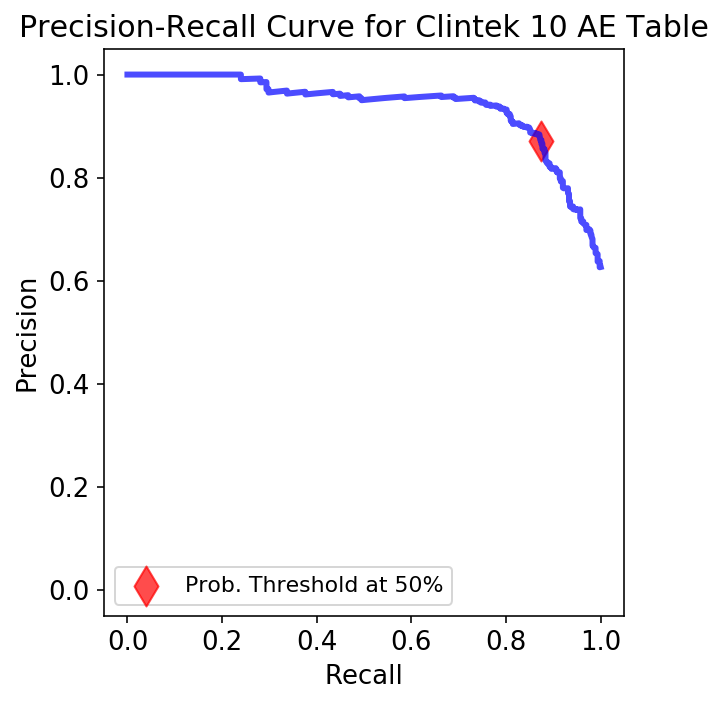

In [10]:
precision, recall, thresholds = pipeline.generate_pr_values()
precision_default = dict_report['True']['precision']
recall_default = dict_report['True']['recall']

fig, ax = plt.subplots(figsize=(5, 5)) 
plt.plot(recall, precision, "-", alpha=0.7, lw=3, color='blue')
ax.scatter(recall_default, precision_default, s=200, alpha=0.7, color='red', marker='d', label='Prob. Threshold at 50%')
plt.xlabel("Recall", fontsize=13, color='black')
plt.ylabel("Precision", fontsize=13, color='black')
plt.title(f"Precision-Recall Curve for Clintek 10 {formoid} Table", fontsize=15)
plt.tick_params(labelsize=13, colors='black')
plt.legend(fontsize=11, loc='lower left')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.tight_layout()

### zero knowledge model performance

In [11]:
# zero knowledge model performance 
dict_ZKM_report = ZKM_performance(df=df)
df_ZKM_report = pd.DataFrame(dict_ZKM_report['True'], index=['True'])
df_ZKM_report['accuracy'] = dict_ZKM_report['accuracy']
display(df_ZKM_report[['accuracy', 'precision', 'recall', 'f1-score', 'support']].round(decimals=3))

accuracy  precision  recall  f1-score  support
True     0.529       0.61   0.623     0.617     3086

# Model Performance Comparison

In [12]:
# select domain tables of interests
list_dfs = [
    df_AE, 
    df_EX, 
    df_CM,
    df_LB_HEME,
    df_VS,
]

list_formoids = [
    "AE", 
    "EX", 
    "CM",
    "LB_HEME",
    "VS",
]

In [13]:
# number of domain-centric model runs
# each run splits the data randomly for training and evaluation to collect statistics of model performance 
num_model_runs = 100

In [14]:
%%time
# calculate domain-centric and zero knowledge model performances for each domain table of interests
list_model_results = []
list_ZKM_results = []

for df, formoid in zip(list_dfs, list_formoids):
    print(f'Modeling {formoid} table ...')
    
    # domain-centric model and performance
    for n in tqdm(range(num_model_runs)):
        pipeline = DomainModeling(
            df=df,
            formoid=formoid,
            valid_size=0.15,
            test_size=0.15,
            log_flag=False,
        )
        pipeline.run()
        dict_report = pipeline.model_evaluate()

        model_results = {}
        model_results['FormOID'] = formoid
        model_results.update(dict_report['True'])
        model_results.update({'accuracy': dict_report['accuracy']})
        list_model_results.append(model_results)

    # zero knowledge model and performance
    dict_ZKM_report = ZKM_performance(df=df)
    
    ZKM_results = {}
    ZKM_results['FormOID'] = formoid
    ZKM_results.update(dict_ZKM_report['True'])
    ZKM_results.update({'accuracy': dict_ZKM_report['accuracy']})
    list_ZKM_results.append(ZKM_results)   

# collect resultant performance as dataframe
df_model_results = pd.DataFrame(list_model_results,)
df_ZKM_results = pd.DataFrame(list_ZKM_results,)

Modeling AE table ...



Modeling EX table ...



Modeling CM table ...



Modeling LB_HEME table ...



Modeling VS table ...



Wall time: 9min 8s


In [15]:
print(f"Domain-centric model performance (from {num_model_runs} model runs)")
df_model_results_stat = calculate_performance_statistics(df_model_results)
display(df_model_results_stat)

Domain-centric model performance (from 100 model runs)


FormOID          accuracy         precision            recall          f1-score     support
0       AE  0.819 (+/-0.013)  0.856 (+/-0.015)  0.845 (+/-0.016)   0.85 (+/-0.011)  463 (+/-0)
1       EX  0.932 (+/-0.007)  0.906 (+/-0.018)  0.841 (+/-0.019)  0.872 (+/-0.014)  363 (+/-0)
2       CM  0.809 (+/-0.012)   0.75 (+/-0.032)  0.612 (+/-0.034)  0.673 (+/-0.023)  280 (+/-0)
3  LB_HEME  0.815 (+/-0.012)  0.836 (+/-0.057)  0.345 (+/-0.046)  0.486 (+/-0.047)  107 (+/-0)
4       VS  0.887 (+/-0.009)  0.728 (+/-0.096)   0.27 (+/-0.052)  0.391 (+/-0.063)   70 (+/-0)

In [16]:
print("Zero knowledge model performance")
display(df_ZKM_results[['FormOID', 'accuracy', 'precision', 'recall', 'f1-score', 'support']].round(decimals=3))

Zero knowledge model performance


FormOID  accuracy  precision  recall  f1-score  support
0       AE     0.526      0.609   0.615     0.612     3086
1       EX     0.606      0.280   0.279     0.279     2419
2       CM     0.565      0.320   0.317     0.318     1864
3  LB_HEME     0.636      0.265   0.241     0.252      715
4       VS     0.770      0.140   0.138     0.139      463